In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.graph_objects as go

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow import keras
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from keras.layers import Input,Dense,Dropout
from keras import regularizers
from keras.models import Model, Sequential 
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from skopt import BayesSearchCV
from sklearn.metrics import precision_recall_curve

from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy import stats
from imblearn.over_sampling import SMOTE




from tensorflow.keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error, mean_absolute_error

from pandas import read_csv
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV


In [2]:
# Import Data
netflixData = pd.read_csv('NFLX.csv')
netflixData2016 = netflixData.iloc[3529:] # taking data from 2016


netflixData.index = pd.to_datetime(netflixData['Date'], format='%Y.%m.%d')
netflixData2016.index = pd.to_datetime(netflixData2016['Date'], format='%Y.%m.%d')

len(netflixData.index), len(netflixData2016.index)

(4874, 1345)

<h1>EDA</h1>

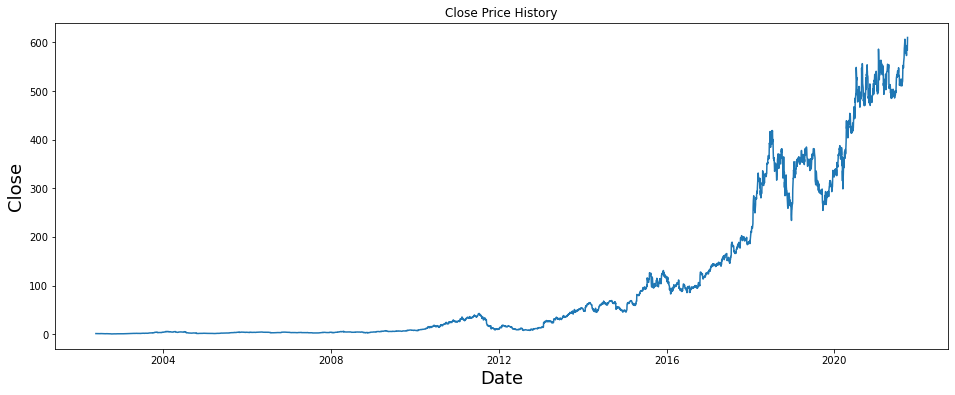

In [3]:
# EDA
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(netflixData['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

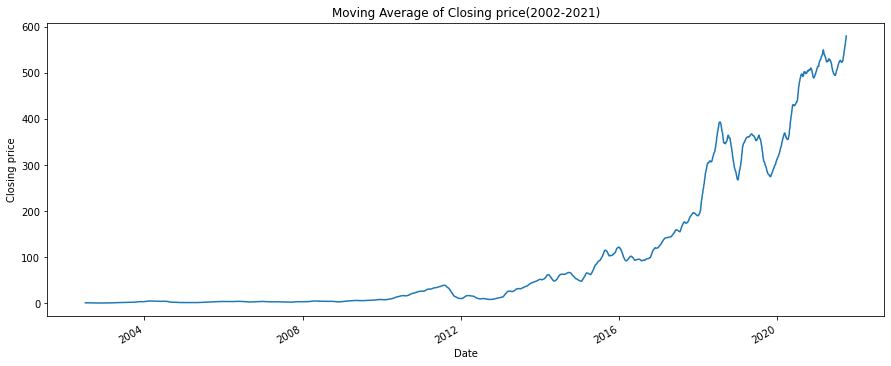

In [4]:
moving_avg = netflixData['Close'].rolling(window=30).mean()
pyplot.figure(figsize=(15,6))
moving_avg.plot()
plt.ylabel('Closing price')
plt.xlabel('Date')
plt.title('Moving Average of Closing price(2002-2021)')
plt.show()

<h1>Data Preprocessing</h1>

In [5]:
# Min Max Scaling
sc = MinMaxScaler(feature_range = (0, 1))
close1 = netflixData[['Close']]
close1 = sc.fit_transform(close1)
netflixData['Close'] = close1
close1 = netflixData['Close']

close2 = netflixData2016[['Close']]
close2 = sc.fit_transform(close2)
netflixData2016['Close'] = close2
close2 = netflixData2016['Close']

close1.shape,close2.shape

<ipython-input-5-ba109607503d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflixData2016['Close'] = close2


((4874,), (1345,))

In [6]:
# Splitting data into batches
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 5
X1, y1 = df_to_X_y(close1, WINDOW_SIZE)
X2, y2 = df_to_X_y(close2, WINDOW_SIZE)
X1.shape, y1.shape, X2.shape, y2.shape

((4869, 5, 1), (4869,), (1340, 5, 1), (1340,))

In [7]:
# Train Test Split the 2002 - 2021 Data
p70 = int(X1.shape[0] *70/100)
p15 = int(X1.shape[0] *15/100)

X_train1, y_train1 = X1[:p70], y1[:p70]
X_val1, y_val1 = X1[p70:p70+p15], y1[p70:p70+p15]
X_test1, y_test1 = X1[p70+p15:], y1[p70+p15:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3408, 5, 1), (3408,), (730, 5, 1), (730,), (731, 5, 1), (731,))

In [8]:
# Train Test Split the 2016 - 2021 Data
p70 = int(X2.shape[0] *70/100)
p15 = int(X2.shape[0] *15/100)

X_train2, y_train2 = X2[:p70], y2[:p70]
X_val2, y_val2 = X2[p70:p70+p15], y2[p70:p70+p15]
X_test2, y_test2 = X2[p70+p15:], y2[p70+p15:]

X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((938, 5, 1), (938,), (201, 5, 1), (201,), (201, 5, 1), (201,))

<h1>Baseline Model</h1>

<h2>Linear Regression</h2>

In [68]:
# 2002 - 2021 Data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
              keras.layers.Dense(1, activation = "linear", input_shape = (5,1)), #input layer
              keras.layers.Flatten(), # flatten layer
              keras.layers.Dense(1, activation = "linear") #output layer     
        ])
optimizer = keras.optimizers.Adam(lr=1e-5)
# Compile the model, optimizer use Adam 
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(X_train1, y_train1, validation_data=(X_val1,y_val1), epochs = 100) # train on 100 epochs

Epoch 1/100
107/107 [==============================] - 1s 3ms/step - loss: 1.4845e-04 - mae: 0.0094 - val_loss: 0.0042 - val_mae: 0.0714
Epoch 2/100
107/107 [==============================] - 0s 2ms/step - loss: 1.2866e-04 - mae: 0.0088 - val_loss: 0.0040 - val_mae: 0.0689
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: 1.1518e-04 - mae: 0.0089 - val_loss: 0.0038 - val_mae: 0.0666
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 1.0634e-04 - mae: 0.0092 - val_loss: 0.0036 - val_mae: 0.0648
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: 1.0067e-04 - mae: 0.0095 - val_loss: 0.0035 - val_mae: 0.0633
Epoch 6/100
107/107 [==============================] - 0s 2ms/step - loss: 9.6877e-05 - mae: 0.0097 - val_loss: 0.0034 - val_mae: 0.0620
Epoch 7/100
107/107 [==============================] - 0s 2ms/step - loss: 9.4101e-05 - mae: 0.0098 - val_loss: 0.0033 - val_mae: 0.0610
Epoch 8/100
107/107 [====================

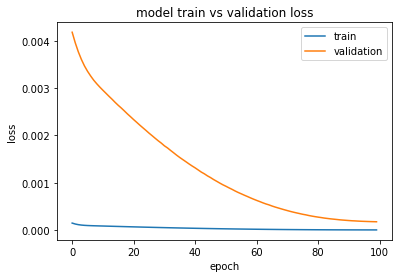

In [69]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

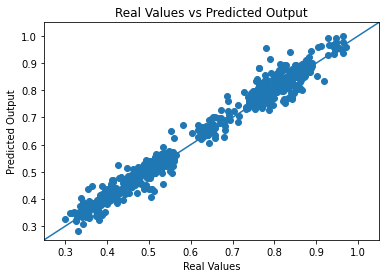

In [70]:
plt.scatter(model.predict(X_test1).flatten(), y_test1)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
plt.title("Real Values vs Predicted Output")
lims = [0.25,1.05]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
plt.show()

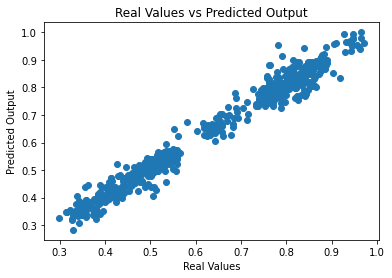

In [71]:
plt.scatter(model.predict(X_test1).flatten(),y_test1)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
plt.title("Real Values vs Predicted Output")
plt.show()

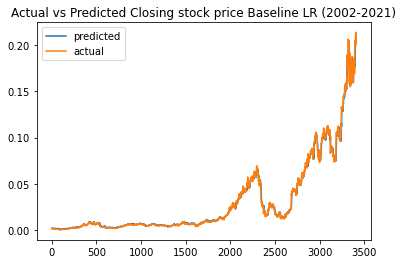

In [72]:
train_predictions = model.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Baseline LR (2002-2021)")
plt.legend()
plt.show()

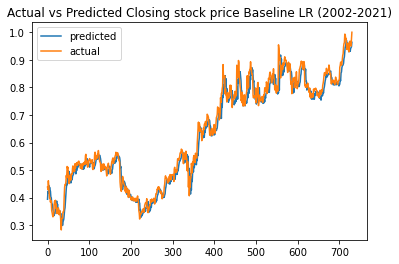

In [73]:
test_predictions = model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'], label = 'predicted')
plt.plot(test_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Baseline LR (2002-2021)")
plt.legend()
plt.show()

In [74]:
model.evaluate(X_test1, y_test1) #loss 4.6907e-04

23/23 [==============================] - 0s 3ms/step - loss: 4.6907e-04 - mae: 0.0226


[0.0004690726927947253, 0.022607993334531784]

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: ", mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("MAE: ", mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))

MSE:  0.000938145342463115
MAE:  0.022607993635999885


In [76]:
# 2016 - 2022 Dataset

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
              keras.layers.Dense(1, activation = "linear", input_shape = (5,1)), #input layer
              keras.layers.Flatten(), # flatten layer
              keras.layers.Dense(1, activation = "linear") #output layer     
        ])
optimizer = keras.optimizers.Adam(lr=1e-5)
# Compile the model, optimizer use Adam 
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(X_train2, y_train2, validation_data=(X_val2,y_val2), epochs = 100) # train on 100 epochs

C:\Users\najmi\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
30/30 [==============================] - 1s 9ms/step - loss: 0.0075 - mae: 0.1041 - val_loss: 0.0292 - val_mae: 0.2372
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0073 - mae: 0.1031 - val_loss: 0.0289 - val_mae: 0.2357
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0072 - mae: 0.1021 - val_loss: 0.0285 - val_mae: 0.2342
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0071 - mae: 0.1011 - val_loss: 0.0282 - val_mae: 0.2327
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0070 - mae: 0.1002 - val_loss: 0.0278 - val_mae: 0.2313
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0992 - val_loss: 0.0275 - val_mae: 0.2298
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0068 - mae: 0.0982 - val_loss: 0.0271 - val_mae: 0.2283
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0067 - m

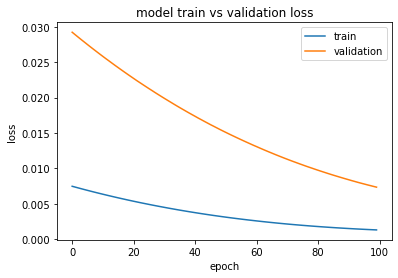

In [77]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

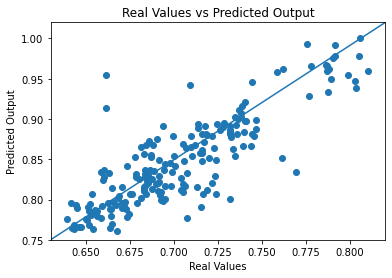

In [78]:
plt.scatter(model.predict(X_test2).flatten(),y_test2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
lims = [0.75,1.02]
lims2 = [0.63,0.82]
plt.xlim(lims2)
plt.ylim(lims)
_ = plt.plot(lims2,lims)
plt.title("Real Values vs Predicted Output")
plt.show()

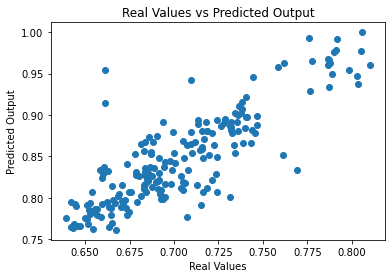

In [79]:
plt.scatter(model.predict(X_test2).flatten(),y_test2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
plt.title("Real Values vs Predicted Output")
plt.show()

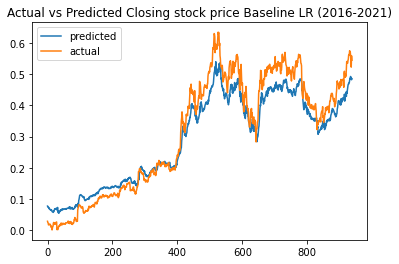

In [80]:
train_predictions = model.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Baseline LR (2016-2021)")
plt.legend()
plt.show()

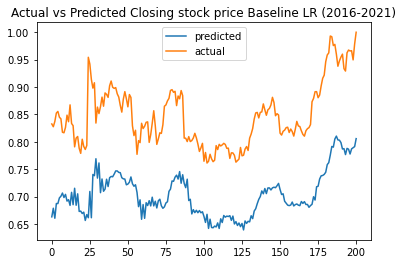

In [81]:
test_predictions = model.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2})
test_results

import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'], label = 'predicted')
plt.plot(test_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Baseline LR (2016-2021)")
plt.legend()
plt.show()

In [82]:
model.evaluate(X_test2, y_test2) #loss 0.0109

7/7 [==============================] - 0s 1ms/step - loss: 0.0109 - mae: 0.1442


[0.010865792632102966, 0.14417944848537445]

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: ", mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("MAE: ", mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))

MSE:  0.021731584340013602
MAE:  0.14417944982574066


<h2>MLP</h2>

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.Dense(50, input_shape=(5,1)), #Dense layers
  keras.layers.Activation('sigmoid'),
  keras.layers.Dense(50),
  keras.layers.Activation('sigmoid'),
  keras.layers.Dense(50),
  keras.layers.Activation('sigmoid'),
  keras.layers.Dense(50),
  keras.layers.Activation('sigmoid'),
  keras.layers.Dense(10),
  keras.layers.Activation('softmax'),
  keras.layers.Flatten(),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Adam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[lr_schedule])

C:\Users\najmi\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
107/107 [==============================] - 2s 7ms/step - loss: 9.8951e-04 - mae: 0.0284 - val_loss: 0.0346 - val_mae: 0.2013
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 9.8769e-04 - mae: 0.0285 - val_loss: 0.0346 - val_mae: 0.2011
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 9.8568e-04 - mae: 0.0285 - val_loss: 0.0345 - val_mae: 0.2009
Epoch 4/100
107/107 [==============================] - 0s 3ms/step - loss: 9.8349e-04 - mae: 0.0286 - val_loss: 0.0345 - val_mae: 0.2007
Epoch 5/100
107/107 [==============================] - 0s 3ms/step - loss: 9.8111e-04 - mae: 0.0287 - val_loss: 0.0344 - val_mae: 0.2005
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: 9.7856e-04 - mae: 0.0287 - val_loss: 0.0344 - val_mae: 0.2003
Epoch 7/100
107/107 [==============================] - 0s 3ms/step - loss: 9.7579e-04 - mae: 0.0288 - val_loss: 0.0343 - val_mae: 0.2001
Epoch 8/100
107/107 [====================

In [9]:
# 2002 - 2021 Data
history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[lr_schedule])

Epoch 1/100
107/107 [==============================] - 0s 3ms/step - loss: 7.2607e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0666
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 7.2438e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0666
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 7.2248e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0665
Epoch 4/100
107/107 [==============================] - 0s 3ms/step - loss: 7.2028e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0665
Epoch 5/100
107/107 [==============================] - 0s 3ms/step - loss: 7.1781e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0665
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: 7.1506e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0664
Epoch 7/100
107/107 [==============================] - 0s 3ms/step - loss: 7.1196e-06 - mae: 0.0021 - val_loss: 0.0071 - val_mae: 0.0664
Epoch 8/100
107/107 [====================

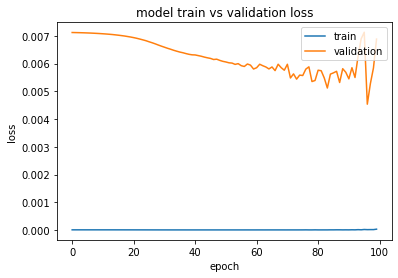

In [10]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

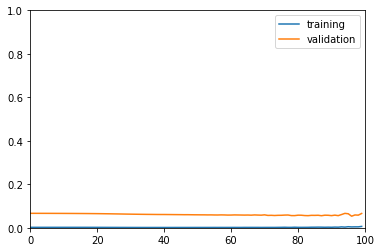

In [11]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training','validation'])
plt.axis([0,100,0, 1])
plt.show()

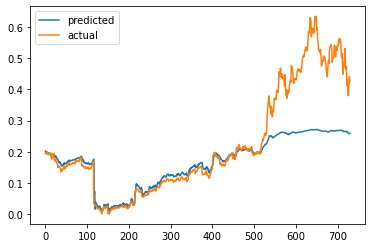

In [12]:
train_predictions = model.predict(X_val1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_val1})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.legend()

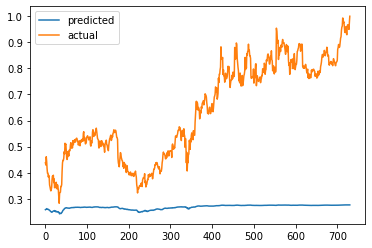

In [13]:
test_predictions = model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'], label = 'predicted')
plt.plot(test_results['Actuals'], label = 'actual')
plt.legend()

In [14]:
# 2016 - 2022 Data
history2 = model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[lr_schedule])

Epoch 1/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0128 - mae: 0.1186 - val_loss: 0.1020 - val_mae: 0.4396
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0128 - mae: 0.1186 - val_loss: 0.1019 - val_mae: 0.4394
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0128 - mae: 0.1185 - val_loss: 0.1018 - val_mae: 0.4392
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0128 - mae: 0.1184 - val_loss: 0.1018 - val_mae: 0.4390
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0128 - mae: 0.1184 - val_loss: 0.1017 - val_mae: 0.4389
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0127 - mae: 0.1183 - val_loss: 0.1016 - val_mae: 0.4387
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0127 - mae: 0.1183 - val_loss: 0.1015 - val_mae: 0.4385
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0127 - m

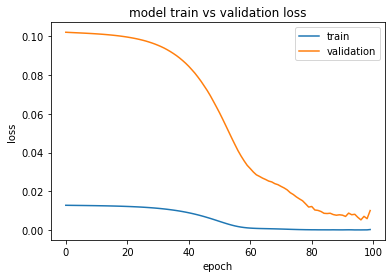

In [15]:
from matplotlib import pyplot 
pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

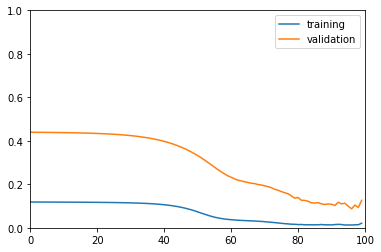

In [16]:
plt.plot(history2.history['mae'])
plt.plot(history2.history['val_mae'])
plt.legend(['training','validation'])
plt.axis([0,100,0, 1])
plt.show()

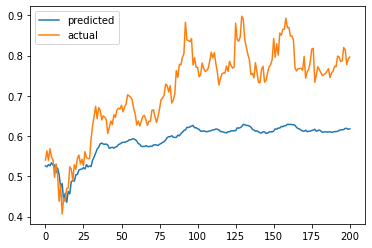

In [17]:
train_predictions = model.predict(X_val2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_val2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.legend()

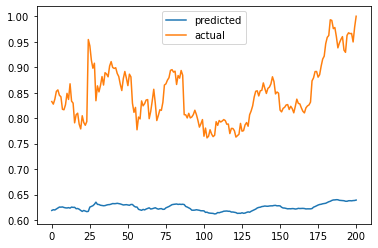

In [18]:
test_predictions = model.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2})
test_results

import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'], label = 'predicted')
plt.plot(test_results['Actuals'], label = 'actual')
plt.legend()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: ", mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))

print("MAE: ", mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))

MSE:  0.05221964901245838
MAE:  0.22291629595246784


<h2>LSTM</h2>

In [20]:
# Baseline Model Definition
baseline = Sequential()

#add 1st lstm layer
baseline.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train1.shape[1], 1)))
baseline.add(Dropout(rate = 0.3))

##add 2nd lstm layer: 50 neurons
baseline.add(LSTM(units = 100, return_sequences = True))
baseline.add(Dropout(rate = 0.3))

##add 3rd lstm layer
baseline.add(LSTM(units = 100, return_sequences = True))
baseline.add(Dropout(rate = 0.3))

##add 4th lstm layer
baseline.add(LSTM(units = 100, return_sequences = False))
baseline.add(Dropout(rate = 0.3))

##add output layer
baseline.add(Dense(units = 1))

baseline.compile(optimizer = 'adam', loss = 'mean_squared_error')

baseline.summary()

# Fit the whole data
history = baseline.fit(x = X_train1, y = y_train1,validation_data=(X_val1, y_val1), batch_size = 32, epochs = 100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 5, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)              

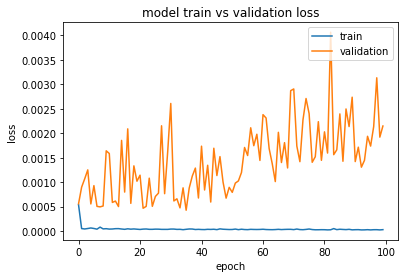

In [21]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

1.0143623353666998e-05

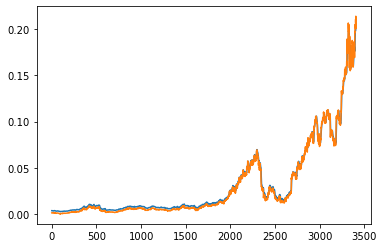

In [22]:
train_predictions = baseline.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

mean_squared_error(train_results['Train Predictions'],train_results['Actuals'])

0.0021487119732279064

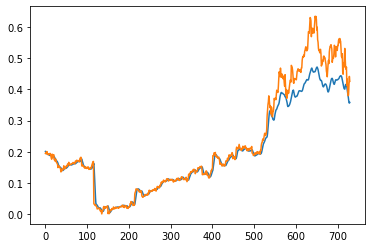

In [23]:
val_predictions = baseline.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

mean_squared_error(val_results['Val Predictions'],val_results['Actuals'])

MAE: 0.18490349242050763
MSE: 0.04963297933737266


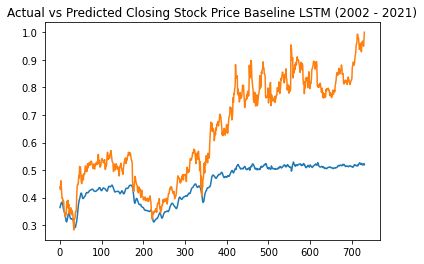

In [25]:
test_predictions = baseline.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.title('Actual vs Predicted Closing Stock Price Baseline LSTM (2002 - 2021)')

print('MAE:',mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))
print('MSE:',mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))

In [26]:
# Fit the 2016 data
history = baseline.fit(x = X_train2, y = y_train2,validation_data=(X_val2, y_val2), batch_size = 32, epochs = 100)

Epoch 1/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 0.0195
Epoch 2/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0015 - val_loss: 0.0277
Epoch 3/100
30/30 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0168
Epoch 4/100
30/30 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 0.0175
Epoch 5/100
30/30 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0112
Epoch 6/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.0096
Epoch 7/100
30/30 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0148
Epoch 8/100
30/30 [==============================] - 1s 20ms/step - loss: 8.4746e-04 - val_loss: 0.0091
Epoch 9/100
30/30 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0131
Epoch 10/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 0.

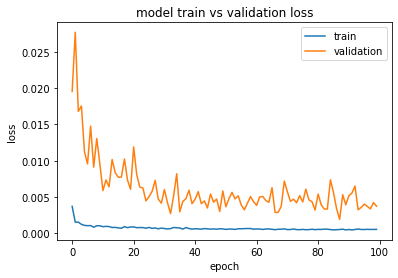

In [27]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

0.0001903626575201099

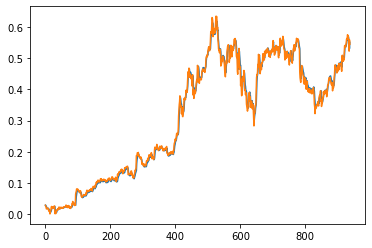

In [28]:
train_predictions = baseline.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

mean_squared_error(train_results['Train Predictions'],train_results['Actuals'])

0.003744906839796823

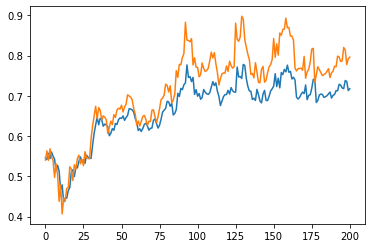

In [29]:
val_predictions = baseline.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2})
val_results

plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

mean_squared_error(val_results['Val Predictions'],val_results['Actuals'])

MAE: 0.10097012361780633
MSE: 0.01134349219793661


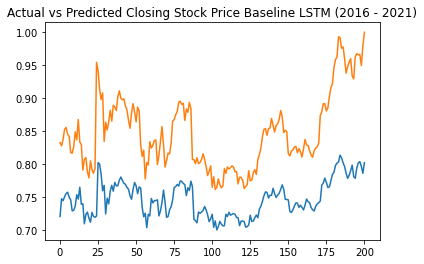

In [30]:
test_predictions = baseline.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2})
test_results

plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.title('Actual vs Predicted Closing Stock Price Baseline LSTM (2016 - 2021)')

print('MAE:',mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))
print('MSE:',mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))

<h1>Hyperparameter Tuning</h1>

<h2>Linear Regression</h2>

In [89]:
# 2002 - 2021 Data

# Hyperparameter Tuning
def model_builder(hp):
    model = Sequential()
    
    model.add(layers.Dense(1, activation = "linear", input_shape = (5,1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = "linear"))

    #Tune learning rate from 0.01, 0.001, 0.0001 for optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Choose Adam Optimizer 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mse', metrics=['mae', 'mse'])
    return model

In [90]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_loss', # objective to optimize
                      max_epochs=250,
                      factor=4, 
                      directory='dir', 
                      overwrite=True,# directory to save logs 
                      project_name='khyperband2')

tuner.search_space_summary() 

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [91]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=20)
# Perform hypertuning
tuner.search(X_train1, y_train1, epochs=200, validation_data=(X_val1,y_val1), callbacks=[stop_early])

Trial 3 Complete [00h 00m 01s]
val_loss: 0.0012222169898450375

Best val_loss So Far: 0.0005649476661346853
Total elapsed time: 00h 00m 05s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [92]:
tuner.results_summary()

Results summary
Results in dir\khyperband2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.0005649476661346853
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.0006116551230661571
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.0012222169898450375


In [93]:
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'units': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten',
    'trainable': True,
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    

In [94]:
history1 = h_model.fit(X_train1, y_train1, epochs = 100, validation_data=(X_val1,y_val1)) # train on 100 epochs

Epoch 1/100
107/107 [==============================] - 1s 3ms/step - loss: 1.2915e-04 - mae: 0.0057 - mse: 1.2915e-04 - val_loss: 5.2822e-04 - val_mae: 0.0138 - val_mse: 5.2822e-04
Epoch 2/100
107/107 [==============================] - 0s 2ms/step - loss: 1.1320e-05 - mae: 0.0018 - mse: 1.1320e-05 - val_loss: 4.7667e-04 - val_mae: 0.0134 - val_mse: 4.7667e-04
Epoch 3/100
107/107 [==============================] - 0s 2ms/step - loss: 1.2279e-05 - mae: 0.0020 - mse: 1.2279e-05 - val_loss: 4.4404e-04 - val_mae: 0.0125 - val_mse: 4.4404e-04
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 1.1277e-05 - mae: 0.0019 - mse: 1.1277e-05 - val_loss: 4.5802e-04 - val_mae: 0.0131 - val_mse: 4.5802e-04
Epoch 5/100
107/107 [==============================] - 0s 2ms/step - loss: 1.0899e-05 - mae: 0.0018 - mse: 1.0899e-05 - val_loss: 4.5534e-04 - val_mae: 0.0126 - val_mse: 4.5534e-04
Epoch 6/100
107/107 [==============================] - 0s 2ms/step - loss: 1.1244e-05 - mae: 0.

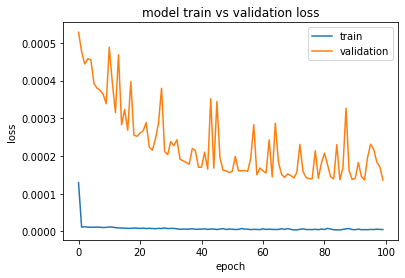

In [95]:
pyplot.plot(history1.history["loss"], label = "train")
pyplot.plot(history1.history["val_loss"], label = "validation")
pyplot.title("model train vs validation loss")
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.legend()
pyplot.show()

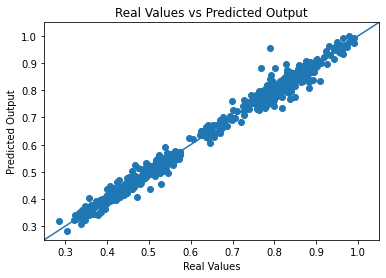

In [96]:
plt.scatter(h_model.predict(X_test1).flatten(), y_test1)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
plt.title("Real Values vs Predicted Output")
lims = [0.25,1.05]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
plt.show()

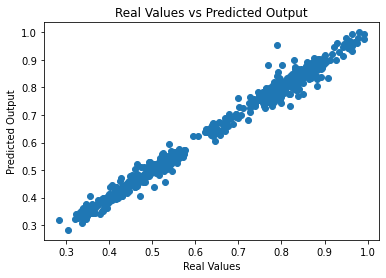

In [97]:
plt.scatter(h_model.predict(X_test1).flatten(),y_test1)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
plt.title("Real Values vs Predicted Output")
plt.show()

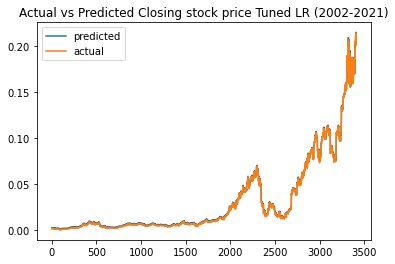

In [98]:
train_predictions = h_model.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Tuned LR (2002-2021)")
plt.legend()
plt.show()

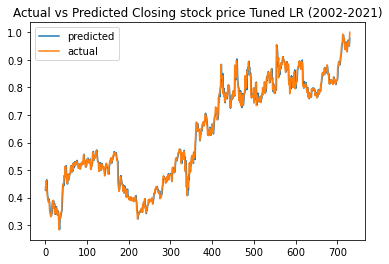

In [99]:
test_predictions = h_model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'], label = 'predicted')
plt.plot(test_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Tuned LR (2002-2021)")
plt.legend()
plt.show()

In [100]:
h_model.evaluate(X_test1, y_test1) #loss 4.0801e-04

23/23 [==============================] - 0s 1ms/step - loss: 4.1723e-04 - mae: 0.0142 - mse: 4.1723e-04


[0.00041723117465153337, 0.014161347411572933, 0.00041723117465153337]

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: ", mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("MAE: ", mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))

MSE:  0.000417231226458075
MAE:  0.014161349495288945


In [102]:
# 2016 - 2021 Data

# Hyperparameter Tuning
# tune learning rate 
def model_builder(hp):
    model = Sequential()
    
    model.add(layers.Dense(1, activation = "linear", input_shape = (5,1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = "linear"))

    #Tune learning rate from 0.01, 0.001, 0.0001 for optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Choose Adam Optimizer 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mse', metrics=['mae', 'mse'])
    return model

In [103]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_loss', # objective to optimize
                      max_epochs=250,
                      factor=4, 
                      directory='dir', 
                      overwrite=True,# directory to save logs 
                      project_name='khyperband2')

tuner.search_space_summary() 

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [104]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=20)
# Perform hypertuning
tuner.search(X_train2, y_train2, epochs=200, validation_data=(X_val2,y_val2), callbacks=[stop_early])

Trial 3 Complete [00h 00m 01s]
val_loss: 0.01828252710402012

Best val_loss So Far: 0.01828252710402012
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [105]:
tuner.results_summary()

Results summary
Results in dir\khyperband2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.01828252710402012
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.06366642564535141
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.12907569110393524


In [106]:
best_hp=tuner.get_best_hyperparameters()[0]
h_model2 = tuner.hypermodel.build(best_hp)
h_model2.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'units': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Flatten',
   'config': {'name': 'flatten',
    'trainable': True,
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    

In [107]:
history2 = h_model2.fit(X_train2, y_train2, epochs = 100, validation_data=(X_val2,y_val2)) # train on 100 epochs

Epoch 1/100
30/30 [==============================] - 1s 10ms/step - loss: 0.0961 - mae: 0.2605 - mse: 0.0961 - val_loss: 0.3418 - val_mae: 0.5768 - val_mse: 0.3418
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0615 - mae: 0.2027 - mse: 0.0615 - val_loss: 0.2395 - val_mae: 0.4808 - val_mse: 0.2395
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0361 - mae: 0.1600 - mse: 0.0361 - val_loss: 0.1565 - val_mae: 0.3861 - val_mse: 0.1565
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0227 - mae: 0.1358 - mse: 0.0227 - val_loss: 0.1047 - val_mae: 0.3132 - val_mse: 0.1047
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0181 - mae: 0.1233 - mse: 0.0181 - val_loss: 0.0809 - val_mae: 0.2735 - val_mse: 0.0809
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0165 - mae: 0.1158 - mse: 0.0165 - val_loss: 0.0695 - val_mae: 0.2526 - val_mse: 0.0695
Epoch 7/100
30/30 [==

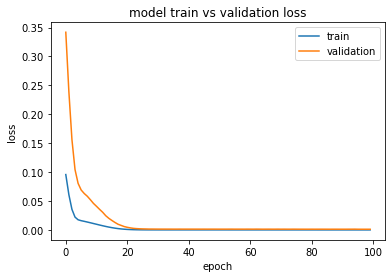

In [108]:
pyplot.plot(history2.history["loss"], label = "train")
pyplot.plot(history2.history["val_loss"], label = "validation")
pyplot.title("model train vs validation loss")
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.legend()
pyplot.show()

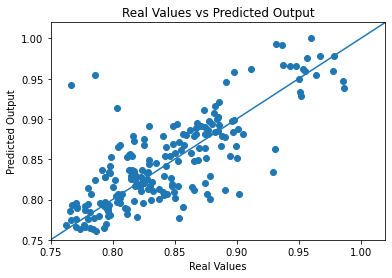

In [109]:
plt.scatter(h_model2.predict(X_test2).flatten(),y_test2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
lims = [0.75,1.02]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
plt.title("Real Values vs Predicted Output")
plt.show()

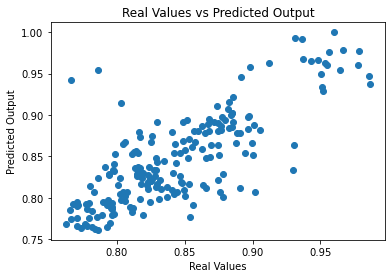

In [110]:
plt.scatter(h_model2.predict(X_test2).flatten(),y_test2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Output")
plt.title("Real Values vs Predicted Output")
plt.show()

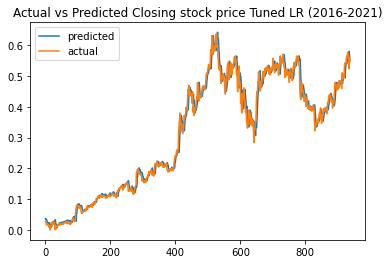

In [111]:
train_predictions = h_model2.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Tuned LR (2016-2021)")
plt.legend()
plt.show()

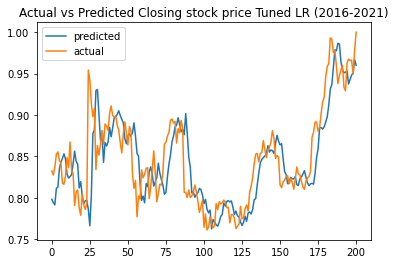

In [112]:
test_predictions = h_model2.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2})
test_results

import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'], label = 'predicted')
plt.plot(test_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price Tuned LR (2016-2021)")
plt.legend()
plt.show()

In [113]:
h_model2.evaluate(X_test2, y_test2) #loss 5.9236e-04

7/7 [==============================] - 0s 1ms/step - loss: 0.0013 - mae: 0.0256 - mse: 0.0013


[0.0012802650453522801, 0.025607261806726456, 0.0012802650453522801]

In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE: ", mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("MAE: ", mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))

MSE:  0.0012802648025611993
MAE:  0.025607256956055282


<h2>MLP</h2>

In [31]:
# Hyperparameter Tuning
from tensorflow.keras.optimizers import SGD, Adam

def model_builder(hp):
    model = Sequential()
    activation = hp.Choice('activation 1', values=['sigmoid','softmax','relu'])
    model.add(Dense(hp.Int('first layer', min_value=50, max_value=200, step=10), activation = activation, input_shape=(5,1))), #Dense layers
    
    for i in range(hp.Int('layers', 1,5)):
        model.add(Dense(hp.Int('hidden layer', min_value=50, max_value=200, step=10), activation=activation)), #Dense layers
    
    model.add(keras.layers.Flatten()),
    model.add(Dense(1))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-6, 1e-7])
    #hp_optimizer = hp.Choice('optimizers', ['SGD', 'Adam'])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),loss='mse', metrics=['mae', 'mse'])
    return model

In [32]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_loss', # objective to optimize
max_epochs=250,
factor=4, 
directory='dir', 
overwrite=True,# directory to save logs 
project_name='khyperband2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=20)
# Perform hypertuning
tuner.search(X_train1, y_train1, epochs=100, validation_data=(X_val1,y_val1), callbacks=[stop_early])

best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.get_config()

Trial 161 Complete [00h 00m 19s]
val_loss: 0.06479459255933762

Best val_loss So Far: 0.002128672320395708
Total elapsed time: 00h 40m 26s
INFO:tensorflow:Oracle triggered exit


{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'units': 170,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 190,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_

In [33]:
history = h_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100
107/107 [==============================] - 2s 8ms/step - loss: 0.0025 - mae: 0.0270 - mse: 0.0025 - val_loss: 0.0690 - val_mae: 0.2016 - val_mse: 0.0690
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0225 - mse: 0.0015 - val_loss: 0.0535 - val_mae: 0.1726 - val_mse: 0.0535
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 9.4909e-04 - mae: 0.0192 - mse: 9.4909e-04 - val_loss: 0.0405 - val_mae: 0.1461 - val_mse: 0.0405
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 5.4044e-04 - mae: 0.0145 - mse: 5.4044e-04 - val_loss: 0.0298 - val_mae: 0.1209 - val_mse: 0.0298
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 2.4914e-04 - mae: 0.0085 - mse: 2.4914e-04 - val_loss: 0.0209 - val_mae: 0.0961 - val_mse: 0.0209
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: 9.7797e-05 - mae: 0.0039 - mse: 9.7797e-05 - val_loss: 0.0150 - val_mae: 0.0

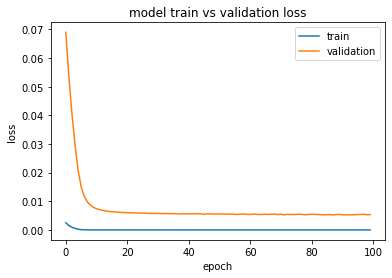

In [34]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

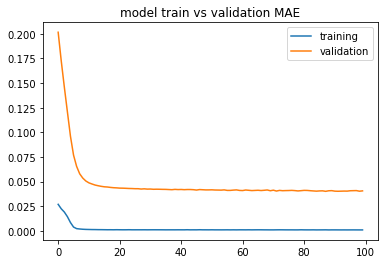

In [35]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training','validation'])
pyplot.title('model train vs validation MAE')
plt.show()

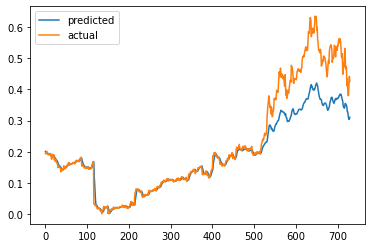

In [36]:
train_predictions = h_model.predict(X_val1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_val1})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.legend()

In [37]:
print("MSE: ", mean_squared_error(train_results['Train Predictions'],train_results['Actuals']))

print("MAE: ", mean_absolute_error(train_results['Train Predictions'],train_results['Actuals']))

MSE:  0.005374546764301615
MAE:  0.04064525322581612


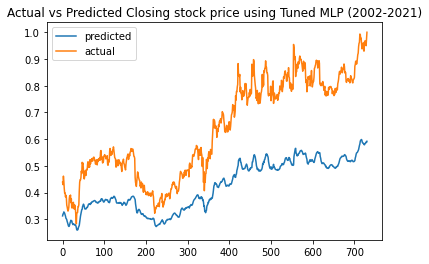

In [38]:
train_predictions = h_model.predict(X_test1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test1})
train_results

plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price using Tuned MLP (2002-2021)")
plt.legend()

In [39]:
print("MSE: ", mean_squared_error(train_results['Train Predictions'],train_results['Actuals']))

print("MAE: ", mean_absolute_error(train_results['Train Predictions'],train_results['Actuals']))

MSE:  0.054056231272343706
MAE:  0.2126597746399639


In [40]:
h_model.save('D:\MMU\Degree.Y3.Sem2\Machine Learning\model 1')

INFO:tensorflow:Assets written to: D:\MMU\Degree.Y3.Sem2\Machine Learning\model 1\assets


In [41]:
# 2016 - 2021 Data

tuner.search(X_train2, y_train2, epochs=100, validation_data=(X_val2,y_val2), callbacks=[stop_early])

best_hp2 =tuner.get_best_hyperparameters()[0]
h_model2 = tuner.hypermodel.build(best_hp2)
h_model2.get_config()

Trial 215 Complete [00h 00m 43s]
val_loss: 0.03392276167869568

Best val_loss So Far: 0.002128672320395708
Total elapsed time: 00h 52m 59s
INFO:tensorflow:Oracle triggered exit


{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'units': 170,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 190,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_

In [42]:
history2 = h_model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100)

Epoch 1/100
30/30 [==============================] - 1s 12ms/step - loss: 0.1371 - mae: 0.3165 - mse: 0.1371 - val_loss: 0.5149 - val_mae: 0.7095 - val_mse: 0.5149
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.1230 - mae: 0.2982 - mse: 0.1230 - val_loss: 0.4660 - val_mae: 0.6748 - val_mse: 0.4660
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.1093 - mae: 0.2797 - mse: 0.1093 - val_loss: 0.4195 - val_mae: 0.6401 - val_mse: 0.4195
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0969 - mae: 0.2618 - mse: 0.0969 - val_loss: 0.3765 - val_mae: 0.6061 - val_mse: 0.3765
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0849 - mae: 0.2439 - mse: 0.0849 - val_loss: 0.3343 - val_mae: 0.5709 - val_mse: 0.3343
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0731 - mae: 0.2252 - mse: 0.0731 - val_loss: 0.2917 - val_mae: 0.5330 - val_mse: 0.2917
Epoch 7/100
30/30 [==

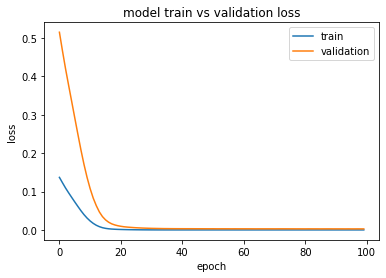

In [43]:
from matplotlib import pyplot 
pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

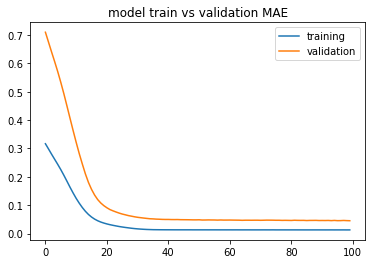

In [44]:
plt.plot(history2.history['mae'])
plt.plot(history2.history['val_mae'])
plt.legend(['training','validation'])
pyplot.title('model train vs validation MAE')
plt.show()

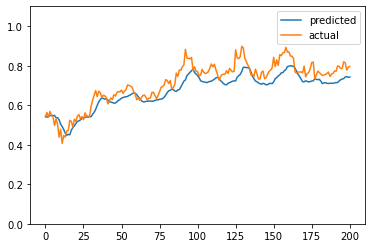

In [45]:
train_predictions = h_model2.predict(X_val2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_val2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.ylim(0,1.1)
plt.legend()

In [46]:
print("MSE: ", mean_squared_error(train_results['Train Predictions'],train_results['Actuals']))

print("MAE: ", mean_absolute_error(train_results['Train Predictions'],train_results['Actuals']))

MSE:  0.0029724041167372975
MAE:  0.0451322713699227


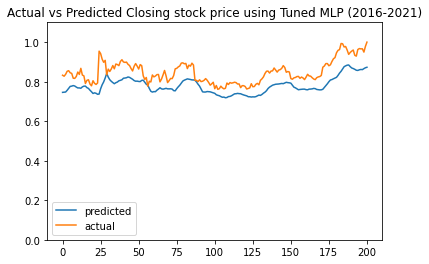

In [47]:
train_predictions = h_model2.predict(X_test2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label = 'predicted')
plt.plot(train_results['Actuals'], label = 'actual')
plt.title("Actual vs Predicted Closing stock price using Tuned MLP (2016-2021)")
plt.ylim(0,1.1)
plt.legend()

In [48]:
print("MSE: ", mean_squared_error(train_results['Train Predictions'],train_results['Actuals']))

print("MAE: ", mean_absolute_error(train_results['Train Predictions'],train_results['Actuals']))

MSE:  0.005547314920957443
MAE:  0.06848664392130961


In [50]:
h_model2.save('D:\MMU\Degree.Y3.Sem2\Machine Learning\model 2')

INFO:tensorflow:Assets written to: D:\MMU\Degree.Y3.Sem2\Machine Learning\model 2\assets


<h2>LSTM</h2>

In [51]:
# Hyperparameter 2002 - 2021
def model_builder(hp):
    model = Sequential()
    
    model.add(LSTM(units = hp.Int('first_unit',min_value=10, max_value =100, step=10.0), return_sequences = True, input_shape = (X_train1.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout_Input',min_value=0.0, max_value =0.5, step=0.05)))
        
    for i in range(hp.Int('layers', 0, 5)):
        model.add(LSTM(units = hp.Int('first_unit',min_value=10, max_value =100, step=10), return_sequences = True))
        model.add(Dropout(rate=hp.Float('dropout_Input',min_value=0.0, max_value =0.5, step=0.05)))
        
    model.add(LSTM(units = hp.Int('first_unit',min_value=10, max_value =100, step=10), return_sequences = False))
    model.add(Dropout(rate=hp.Float('dropout_Input',min_value=0.0, max_value =0.5, step=0.05)))
        
    model.add(Dense(1,name='last'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mse', metrics=['mae', 'mse'])
    return model

In [52]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_loss', # objective to optimize
max_epochs=250,
factor=4, 
directory='dir', 
overwrite=True,# directory to save logs 
project_name='khyperband2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=20)
# Perform hypertuning
tuner.search(X_train1, y_train1, epochs=200, validation_data=(X_val1,y_val1), callbacks=[stop_early])

best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.get_config()

Trial 161 Complete [00h 06m 01s]
val_loss: 0.0012014888925477862

Best val_loss So Far: 0.00015618650650139898
Total elapsed time: 04h 22m 31s
INFO:tensorflow:Oracle triggered exit


{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lstm_input'}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 80,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activit

In [53]:
h_model.save('allDataModel_tuneLayers')

INFO:tensorflow:Assets written to: allDataModel_tuneLayers\assets


INFO:tensorflow:Assets written to: allDataModel_tuneLayers\assets


In [54]:
# Hyperparameter 2016 - 2021
def model_builder(hp):
    model = Sequential()
    
    model.add(LSTM(units = hp.Int('first_unit',min_value=10, max_value =100, step=10.0), return_sequences = True, input_shape = (X_train2.shape[1], 1)))
    model.add(Dropout(rate=hp.Float('dropout_Input',min_value=0.0, max_value =0.5, step=0.05)))
        
    for i in range(hp.Int('layers', 0, 5)):
        model.add(LSTM(units = hp.Int('first_unit',min_value=10, max_value =100, step=10), return_sequences = True))
        model.add(Dropout(rate=hp.Float('dropout_Input',min_value=0.0, max_value =0.5, step=0.05)))
        
    model.add(LSTM(units = hp.Int('first_unit',min_value=10, max_value =100, step=10), return_sequences = False))
    model.add(Dropout(rate=hp.Float('dropout_Input',min_value=0.0, max_value =0.5, step=0.05)))
        
    model.add(Dense(1,name='last'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mse', metrics=['mae', 'mse'])
    return model

In [55]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_loss', # objective to optimize
max_epochs=250,
factor=4, 
directory='dir', 
overwrite=True,# directory to save logs 
project_name='khyperband2')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=20)
# Perform hypertuning
tuner.search(X_train2, y_train2, epochs=200, validation_data=(X_val2,y_val2), callbacks=[stop_early])

best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.get_config()

Trial 161 Complete [00h 01m 05s]
val_loss: 0.0009895528201013803

Best val_loss So Far: 0.0006330293253995478
Total elapsed time: 01h 11m 20s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lstm_input'}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'batch_input_shape': (None, 5, 1),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 60,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activit

In [56]:
h_model.save('2016Model_tuneLayers')

INFO:tensorflow:Assets written to: 2016Model_tuneLayers\assets


INFO:tensorflow:Assets written to: 2016Model_tuneLayers\assets


In [24]:
model = keras.models.load_model('allDataModel_tuneLayers')
history = model.fit(x = X_train1, y = y_train1,validation_data=(X_val1, y_val1), batch_size = 32, epochs = 100)

Epoch 1/100
107/107 [==============================] - 10s 32ms/step - loss: 5.6877e-06 - mae: 0.0015 - mse: 5.6877e-06 - val_loss: 1.4353e-04 - val_mae: 0.0070 - val_mse: 1.4353e-04
Epoch 2/100
107/107 [==============================] - 2s 18ms/step - loss: 4.4593e-06 - mae: 0.0013 - mse: 4.4593e-06 - val_loss: 2.9061e-04 - val_mae: 0.0106 - val_mse: 2.9061e-04
Epoch 3/100
107/107 [==============================] - 2s 18ms/step - loss: 4.0675e-06 - mae: 0.0012 - mse: 4.0675e-06 - val_loss: 2.0127e-04 - val_mae: 0.0082 - val_mse: 2.0127e-04
Epoch 4/100
107/107 [==============================] - 2s 18ms/step - loss: 4.4089e-06 - mae: 0.0013 - mse: 4.4089e-06 - val_loss: 2.1455e-04 - val_mae: 0.0085 - val_mse: 2.1455e-04
Epoch 5/100
107/107 [==============================] - 2s 18ms/step - loss: 3.5035e-06 - mae: 0.0011 - mse: 3.5035e-06 - val_loss: 2.3445e-04 - val_mae: 0.0090 - val_mse: 2.3445e-04
Epoch 6/100
107/107 [==============================] - 2s 19ms/step - loss: 4.3354e-06 - 

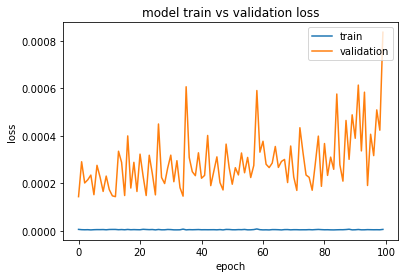

In [30]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')

pyplot.show()

8.048983980893522e-06

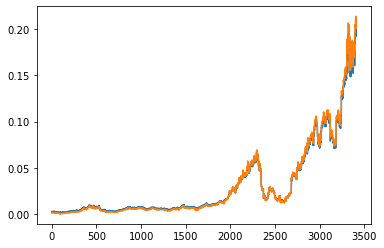

In [26]:
train_predictions = model.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

mean_squared_error(train_results['Train Predictions'],train_results['Actuals'])

0.000836172337733954

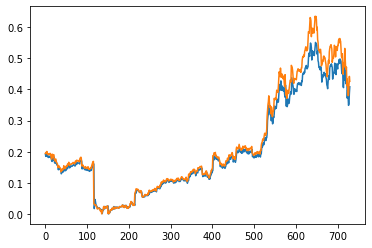

In [27]:
val_predictions = model.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

mean_squared_error(val_results['Val Predictions'],val_results['Actuals'])

MAE: 0.09740065809329156
MSE: 0.012940775261424994


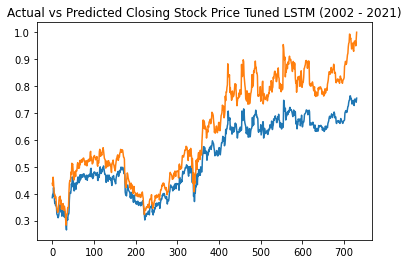

In [28]:
test_predictions = model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.title('Actual vs Predicted Closing Stock Price Tuned LSTM (2002 - 2021)')

print('MAE:',mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))
print('MSE:',mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))

In [62]:
model = keras.models.load_model('2016Model_tuneLayers')

history = model.fit(x = X_train2, y = y_train2,validation_data=(X_val2, y_val2), batch_size = 32, epochs = 100)

Epoch 1/100
30/30 [==============================] - 6s 44ms/step - loss: 0.0347 - mae: 0.1401 - mse: 0.0347 - val_loss: 0.0329 - val_mae: 0.1748 - val_mse: 0.0329
Epoch 2/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0034 - mae: 0.0469 - mse: 0.0034 - val_loss: 0.0018 - val_mae: 0.0320 - val_mse: 0.0018
Epoch 3/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0285 - mse: 0.0016 - val_loss: 0.0017 - val_mae: 0.0312 - val_mse: 0.0017
Epoch 4/100
30/30 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0277 - mse: 0.0015 - val_loss: 0.0015 - val_mae: 0.0298 - val_mse: 0.0015
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 0.0016 - mae: 0.0280 - mse: 0.0016 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 6/100
30/30 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0273 - mse: 0.0014 - val_loss: 0.0020 - val_mae: 0.0343 - val_mse: 0.0020
Epoch 7/100
30/3

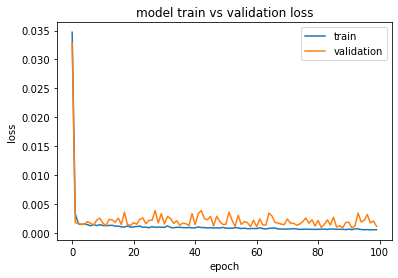

In [63]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

0.0003139799566542519

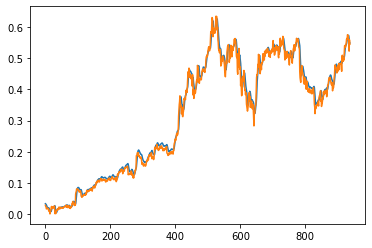

In [64]:
train_predictions = model.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2})
train_results

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

mean_squared_error(train_results['Train Predictions'],train_results['Actuals'])

0.001160917699506201

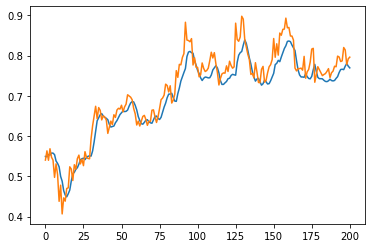

In [65]:
val_predictions = model.predict(X_val2).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val2})
val_results

plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

mean_squared_error(val_results['Val Predictions'],val_results['Actuals'])

MAE: 0.03796213123828148
MSE: 0.001959996606590068


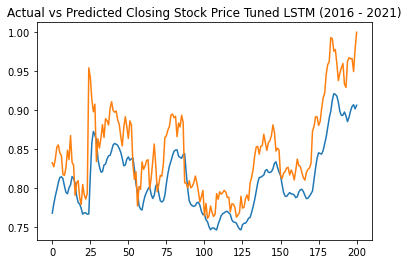

In [66]:
test_predictions = model.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2})
test_results

plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.title('Actual vs Predicted Closing Stock Price Tuned LSTM (2016 - 2021)')

print('MAE:',mean_absolute_error(test_results['Test Predictions'],test_results['Actuals']))
print('MSE:',mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))